In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import sys
import os
from training.feature_extraction import extract_features  # your multi-dim function
from training.preprocess import _group_and_window, preprocess_and_window_with_dates, _group_and_window_with_dates
from utils.bilstm import data_reshape
project_root = os.path.abspath(os.path.join(os.getcwd(), '../'))  # return the projest's root folder
sys.path.append(project_root)
from utils import data_reshape, split_helper, load_parameters

2025-04-16 00:33:30.797451: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 00:33:30.798301: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-16 00:33:30.800910: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-16 00:33:30.807763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744756410.820002 3024810 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744756410.82

In [2]:
import pandas as pd
import numpy as np
import pickle
from functools import partial
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#!/usr/bin/env python
# coding: utf-8

"""
A script/notebook to compare BiLSTM vs LightGBM across multiple window sizes
for one or more datasets (e.g. 'st', 'randomized').
Assumes:
 - Each window-specific BiLSTM model is saved at models/bilstm/{dataset}_bilstm_win{w}.h5
 - The single LightGBM model is saved at models/lightgbm/{dataset}_model.pkl
 - multi_window_size is defined in your .yaml files
 - The same data_path + CSV structure is used for test sets
"""
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

# Local modules (adjust imports if your structure is different)
from training.preprocess import preprocess_and_window, load_parameters
from training.feature_extraction import extract_features

In [3]:
# BILSTM model -----------------------------------------------------------------------
# the input features of the BiLSTM model
features_bilstm = ['voltage', 'current', 'temperature', 'relativeTime']
labels_bilstm = ['capacity']

# load the model


# the BiLSTM model's input features need to be normalized
folder_path = 'data/st/'
path_dict = {'train': f'{folder_path}train.csv',
             'valid': f'{folder_path}valid.csv',
             'test': f'{folder_path}test.csv'}
data_dict = {key: pd.read_csv(path) for key, path in path_dict.items()}
data = pd.concat(data_dict, axis=0)
scaler = MinMaxScaler()
data[features_bilstm] = scaler.fit_transform(data[features_bilstm])
# split tha dataset into train, valid, test
#unique_cycles = data['cycle'].unique()
# Example: 70% train+val, 30% test
#trainval_cycles, test_cycles = train_test_split(
#    unique_cycles, test_size=0.2, random_state=42
#)
test_lgb = pd.read_csv('data/st/test.csv')
# BILSTM model ------------------------------------------------------------------------



In [4]:
train = pd.read_csv('data/st/train.csv')
valid = pd.read_csv('data/st/valid.csv')
test_bilstm = pd.read_csv('data/st/test.csv')

scaler = MinMaxScaler()
train[features_bilstm] = scaler.fit_transform(train[features_bilstm])
valid[features_bilstm] = scaler.transform(valid[features_bilstm])


In [5]:
# LightGBM model -----------------------------------------------------------------------
# the input features of the LightGBM model
params = load_parameters('training/lightgbm.yaml').datasets['st']
features_lgb = params['feature_list']
labels_lgb = params['labels']

# load the model
# with open('model_lightgbm/model_pruning/pruned_nasa_3features_first20_01886500/pruned_110trees_0199.pkl', 'rb') as file:
#     model_lgb = pickle.load(file)
with open('models/lightgbm/lgbm_st_model.pkl', 'rb') as file:
    model_lgb = pickle.load(file)

# the testing data
test_lgb = pd.read_csv('data/st/test.csv')
# LightGBM model -----------------------------------------------------------------------

In [6]:
data_groupby = params['data_groupby']
# step_len_list = [5, 10, 15, 20, 30, 40, 50, 70, 100]
step_len_list = [20]
# step_len_list = [5, 10, 15, 20, 30, 40, 50]

# get the group size
group_sizes = test_lgb.groupby(data_groupby).size()
max_group_length, min_group_length = group_sizes.max(), group_sizes.min()
print(f"--group length: max={max_group_length}, min={min_group_length}\n")
fixed_group_length = min_group_length

# test and save the result onto dataframe
columns = ['model', 'step_length', 'ordinal', 'MAE', 'loss']
result = pd.DataFrame(columns=columns)

--group length: max=360, min=175



/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


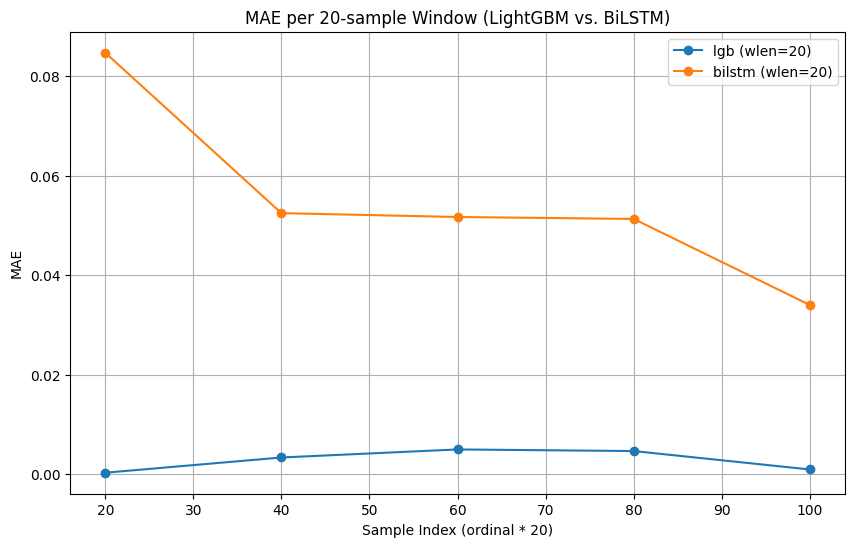

Number of points where LightGBM outperforms BiLSTM: 66.82692307692307%

LightGBM - overall MAE at wlen=20: 0.0156
BiLSTM   - overall MAE at wlen=20: 0.0263


In [10]:
# ---------------------------------------------------------------------
# 5) Build 20-sample windows from the test set
# ---------------------------------------------------------------------
step_len = 20  # Your chosen fixed window length
overlap = 0    # No overlap, so it slices [0..19], [20..39], etc.

X_list, y_list, test_dates = _group_and_window_with_dates(
    df=test_lgb,  # test data
    features=params['raw_features'],   # columns used as raw input
    labels=params['labels'],           # columns for target
    window_length=step_len,
    overlap=overlap,
    date_col=params['date_col'],  # date column
    group_cols=params['data_groupby']
)
# X_list is a list of arrays each shaped (20, len(raw_features))
# y_list is a list of scalars (if 1D label)

if len(X_list) == 0:
    print("No 20-sample windows created from the test data. Exiting.")
    exit()

# Convert to NumPy
X_test_windows = np.array(X_list, dtype=np.float32)    # shape => (N_windows, 20, len(raw_features))
y_test_windows = np.array(y_list, dtype=np.float32)    # shape => (N_windows,)

#X_test_windows_bilstm = np.array([scaler.transform(X_list[i]) for i in range(len(X_list))],)
X_test_windows_bilstm = np.array([
    scaler.transform(pd.DataFrame(X_list[i], columns=params['raw_features']))
    for i in range(len(X_list))
], dtype=np.float32)
# ---------------------------------------------------------------------
# 6) LightGBM Prediction: First extract features from (N_windows, 20, #features)
# ---------------------------------------------------------------------
X_test_lgb = extract_features(
    data=X_test_windows,
    raw_features=params['raw_features'],
    feature_list=params['feature_list']
)
# shape => (N_windows, extracted_feature_dim)

preds_lgb = model_lgb.predict(X_test_lgb)  # shape => (N_windows,)

# Per-window absolute errors
abs_err_lgb = np.abs(preds_lgb.ravel() - y_test_windows.ravel())


model_bilstm_path = 'models/bilstm/st_bilstm_'
model_bilstm_dict = {
    '5': f'{model_bilstm_path}win5.h5',
    '10': f'{model_bilstm_path}win10.h5',
    #'15': f'{model_bilstm_path}15.keras',
    '20': f'{model_bilstm_path}win20.h5',
    #'20': f'download/ST_BiLSTM_st.keras',
    '30': f'{model_bilstm_path}win30.h5',
    '40': f'{model_bilstm_path}win40.h5',
    '50': f'{model_bilstm_path}win50.h5',
}
model_bilstm = tf.keras.models.load_model(model_bilstm_dict['20'], custom_objects={'mae': MeanSquaredError()})
#model_bilstm = tf.keras.models.load_model("models/bilstm/ST_BiLSTM_st.keras", custom_objects={'mae': MeanAbsoluteError()})
# ---------------------------------------------------------------------
# 7) BiLSTM Prediction: Feed raw (N_windows, 20, #features) directly
# ---------------------------------------------------------------------
preds_bilstm = model_bilstm.predict(X_test_windows_bilstm)  # shape => (N_windows,)
abs_err_bilstm = np.abs(preds_bilstm.ravel() - y_test_windows.ravel())


# ---------------------------------------------------------------------
# 8) Build a result DataFrame and plot the per-window MAE
# ---------------------------------------------------------------------
N_windows = len(X_test_windows)

results = []
for i in range(N_windows):
    # "ordinal" is just the i-th window (1-based index)
    ordinal = i + 1
    results.append({
        "model": "lgb",
        "step_length": step_len,
        "ordinal": ordinal,
        "MAE": abs_err_lgb[i]
    })
    results.append({
        "model": "bilstm",
        "step_length": step_len,
        "ordinal": ordinal,
        "MAE": abs_err_bilstm[i]
    })

df_results = pd.DataFrame(results)

# Plot
plt.figure(figsize=(10, 6))
plt.title(f"MAE per 20-sample Window (LightGBM vs. BiLSTM)")

for model_name in df_results["model"].unique():
    # Subset for each model
    subset = df_results[df_results["model"] == model_name]
    # For X, you can multiply ordinal by 20 to reflect the sample index in the series
    xvals = subset["ordinal"] * step_len
    yvals = subset["MAE"]
    plt.plot(
        xvals[:5], 
        yvals[1:6],
        marker="o",
        linestyle="-",
        label=f"{model_name} (wlen=20)"
    )
    # Calculate the number of points where LightGBM outperforms BiLSTM and vice versa
    
plt.xlabel("Sample Index (ordinal * 20)")
plt.ylabel("MAE")
plt.grid(True)
plt.legend()
plt.show()
# To resolve the warnings, ensure that the input to the scaler has valid feature names.
# Use a DataFrame instead of a NumPy array for transformation.

# ---------------------------------------------------------------------
# 9) (Optional) Print Overall MAE
# ---------------------------------------------------------------------
lgb_better = (abs_err_lgb < abs_err_bilstm).sum()/ len(abs_err_lgb)*100
#bilstm_better = (abs_err_bilstm < abs_err_lgb).sum()

print(f"Number of points where LightGBM outperforms BiLSTM: {lgb_better}%")
#print(f"Number of points where BiLSTM outperforms LightGBM: {bilstm_better}")
print()
avg_mae_lgb = abs_err_lgb.mean()
avg_mae_bilstm = abs_err_bilstm.mean()
print(f"LightGBM - overall MAE at wlen=20: {avg_mae_lgb:.4f}")
print(f"BiLSTM   - overall MAE at wlen=20: {avg_mae_bilstm:.4f}")



=== Evaluating dataset: st ===

Window sizes to evaluate: [10, 20, 30, 40, 50]

--- Window size = 10 ---
  BILSTM Test data shape: (851, 10, 4)
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
  BILSTM Test MAE: 0.018947


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM Test data shape (extracted features): (851, 6)
  LightGBM Test MAE: 0.018516

--- Window size = 20 ---
  BILSTM Test data shape: (416, 20, 4)
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
  BILSTM Test MAE: 0.026323


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM Test data shape (extracted features): (416, 6)
  LightGBM Test MAE: 0.015626

--- Window size = 30 ---
  BILSTM Test data shape: (269, 30, 4)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
  BILSTM Test MAE: 0.032441


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM Test data shape (extracted features): (269, 6)
  LightGBM Test MAE: 0.015017

--- Window size = 40 ---
  BILSTM Test data shape: (203, 40, 4)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
  BILSTM Test MAE: 0.041561
  LightGBM Test data shape (extracted features): (203, 6)
  LightGBM Test MAE: 0.013386

--- Window size = 50 ---


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  BILSTM Test data shape: (160, 50, 4)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
  BILSTM Test MAE: 0.044467
  LightGBM Test data shape (extracted features): (160, 6)
  LightGBM Test MAE: 0.013823


=== Evaluating dataset: randomized ===

Window sizes to evaluate: [10, 20, 30, 40, 50]

--- Window size = 10 ---


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  BILSTM Test data shape: (699, 10, 4)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
  BILSTM Test MAE: 1.180275
  LightGBM Test data shape (extracted features): (699, 12)
  LightGBM Test MAE: 2.652449

--- Window size = 20 ---
  BILSTM Test data shape: (340, 20, 4)


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
  BILSTM Test MAE: 3.103860
  LightGBM Test data shape (extracted features): (340, 12)
  LightGBM Test MAE: 2.415190

--- Window size = 30 ---
  BILSTM Test data shape: (218, 30, 4)


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
  BILSTM Test MAE: 4.544897
  LightGBM Test data shape (extracted features): (218, 12)


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  LightGBM Test MAE: 2.369003

--- Window size = 40 ---
  BILSTM Test data shape: (161, 40, 4)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
  BILSTM Test MAE: 17.645147
  LightGBM Test data shape (extracted features): (161, 12)
  LightGBM Test MAE: 2.365040

--- Window size = 50 ---


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  BILSTM Test data shape: (123, 50, 4)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
  BILSTM Test MAE: 17.734785
  LightGBM Test data shape (extracted features): (123, 12)
  LightGBM Test MAE: 2.089241


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


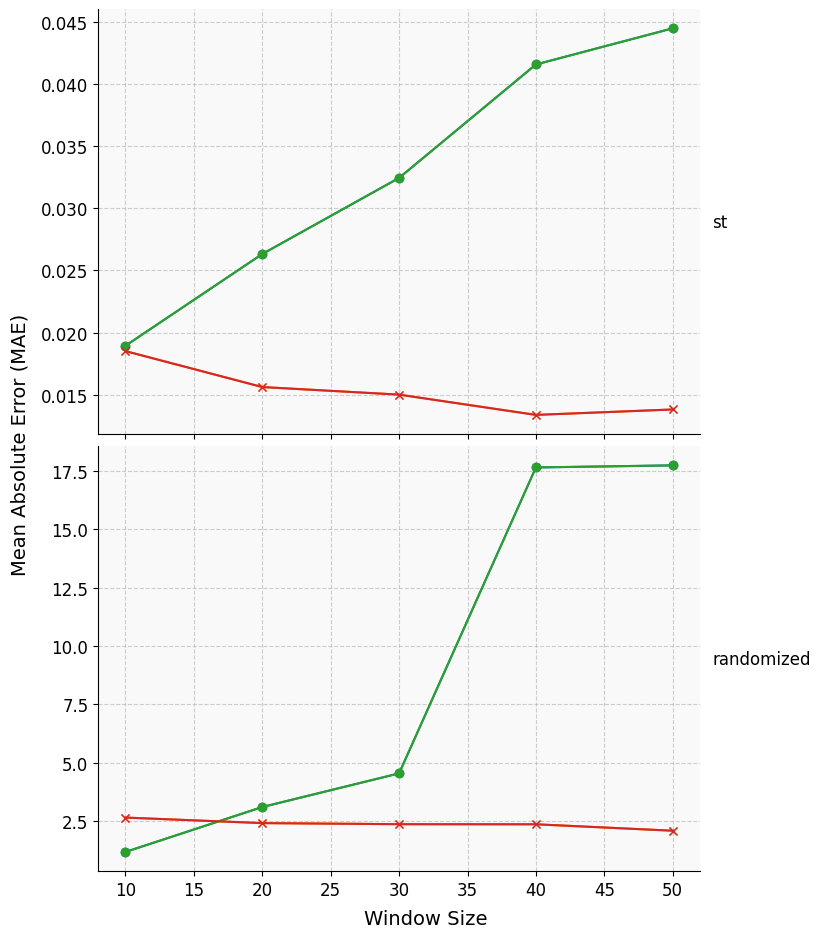

In [ ]:


##############################################################################
# 1) Choose which datasets to evaluate
##############################################################################
# If you only have 'st' and 'randomized', set them here:
DATASETS = ["st", "randomized"]  # or just ["st"] if you only want one.

##############################################################################
# 2) Prepare a figure for subplots (one subplot per dataset)
##############################################################################
fig, axes = plt.subplots(nrows=len(DATASETS), ncols=1, figsize=(8, 5 * len(DATASETS)), sharex=True, sharey=False)

if not isinstance(axes, np.ndarray):
    # If there's only one dataset in the list, 'axes' won't be an array.
    axes = [axes]  # make it iterable

##############################################################################
# 3) Loop over each dataset, evaluate BiLSTM vs LightGBM across windows
##############################################################################
for i, ds_name in enumerate(DATASETS):
    ax = axes[i]
    print(f"\n\n=== Evaluating dataset: {ds_name} ===\n")

    ##########################################################################
    # 3.1) Load configurations for BiLSTM and LightGBM
    #      We'll read both YAML files to get the needed info.
    ##########################################################################
    params_bilstm = load_parameters("training/bilstm.yaml", dataset_override=ds_name)
    params_lgb    = load_parameters("training/lightgbm.yaml", dataset_override=ds_name)

    # We'll gather the window sizes from the same config you used to train them.
    # Typically, you'd find these in both configs, or just pick one of them.
    window_sizes = []
    if hasattr(params_bilstm, "multi_window_size"):
        window_sizes = params_bilstm.multi_window_size[1:]
    elif hasattr(params_lgb, "multi_window_size"):
        window_sizes = params_lgb.multi_window_size[1:]
    else:
        # fallback if no multi_window_size
        window_sizes = [params_bilstm.sequence_length]

    print(f"Window sizes to evaluate: {window_sizes}")

    ##########################################################################
    # 3.2) Load LightGBM model
    ##########################################################################
    lgbm_model_path = f"models/lightgbm/lgbm_{ds_name}_model.pkl"
    if not os.path.exists(lgbm_model_path):
        print(f"WARNING: LightGBM model not found: {lgbm_model_path}")
        print("Skipping LightGBM evaluation...")
        lgbm_maes = [None] * len(window_sizes)
        lightgbm_available = False
    else:
        with open(lgbm_model_path, "rb") as f:
            lgbm_model = pickle.load(f)
        lightgbm_available = True
        lgbm_maes = []

    ##########################################################################
    # 3.3) Evaluate BiLSTM across multiple window sizes
    ##########################################################################
    bilstm_maes = []
    for w in window_sizes:
        print(f"\n--- Window size = {w} ---")

        ######################################################################
        # (a) Prepare test data for that window
        ######################################################################
        # BILSTM uses the raw numeric windows from `params_bilstm.features`
        ( _, _, _, _, test_s_bi, test_t_bi, _, _, _) = preprocess_and_window_with_dates(
            data_path    = params_bilstm.data_path,
            sequence_length = w,
            overlap      = params_bilstm.overlap,
            normalize    = params_bilstm.normalize,
            features     = params_bilstm.features,
            labels       = params_bilstm.labels,
            date_col     = params_bilstm.date_col,
            data_groupby = params_bilstm.data_groupby
        )
        print(f"  BILSTM Test data shape: {test_s_bi.shape}")

        # (b) Load the BiLSTM model for this window size
        bilstm_path = f"models/bilstm/{ds_name}_bilstm_win{w}.h5"
        if not os.path.exists(bilstm_path):
            print(f"  WARNING: BiLSTM model not found at {bilstm_path}")
            bilstm_maes.append(None)
        else:
            bilstm_model = tf.keras.models.load_model(bilstm_path, custom_objects={'mae': MeanSquaredError()})
            pred_bi = bilstm_model.predict(test_s_bi)
            mae_bi = mean_absolute_error(test_t_bi, pred_bi)
            bilstm_maes.append(mae_bi)
            print(f"  BILSTM Test MAE: {mae_bi:.6f}")

        ######################################################################
        # (c) Evaluate LightGBM for this window size (same test *samples*)
        ######################################################################
        if lightgbm_available:
            # LightGBM was trained on extracted features, so do the same extraction
            ( _, _, _, _, test_s_lgb, test_t_lgb, _, _, _) = preprocess_and_window_with_dates(
                data_path    = params_lgb.data_path,
                sequence_length = w,
                overlap      = params_lgb.overlap,
                normalize    = params_lgb.normalize,
                features     = params_lgb.raw_features,
                labels       = params_lgb.labels,
                date_col     = params_lgb.date_col,
                data_groupby = params_lgb.data_groupby
            )
            # Convert raw windows to final feature set
            test_s_lgb = extract_features(test_s_lgb, params_lgb.raw_features, params_lgb.feature_list)
            print(f"  LightGBM Test data shape (extracted features): {test_s_lgb.shape}")

            lgb_pred = lgbm_model.predict(test_s_lgb)
            mae_lgb = mean_absolute_error(test_t_lgb, lgb_pred)
            lgbm_maes.append(mae_lgb)
            print(f"  LightGBM Test MAE: {mae_lgb:.6f}")

    ##########################################################################
    # 3.4) Plot the results for this dataset
    ##########################################################################
    # Some datasets might not have valid LightGBM or BILSTM arrays, so handle that:
    if len(bilstm_maes) == len(window_sizes):
        ax.plot(window_sizes, bilstm_maes, marker='o', label='BiLSTM MAE')
    if lightgbm_available and len(lgbm_maes) == len(window_sizes):
        ax.plot(window_sizes, lgbm_maes, marker='x', label='LightGBM MAE')

    ##############################################################################
    # 3.4) Plot the results for this dataset
    ##############################################################################
    # Some datasets might not have valid LightGBM or BILSTM arrays, so handle that:
    if len(bilstm_maes) == len(window_sizes):
        ax.plot(window_sizes, bilstm_maes, marker='o', label='BiLSTM MAE')
    if lightgbm_available and len(lgbm_maes) == len(window_sizes):
        ax.plot(window_sizes, lgbm_maes, marker='x', label='LightGBM MAE')

    # Add the dataset name to the right of each subplot
    ax.text(1.02, 0.5, ds_name, transform=ax.transAxes, fontsize=12, va='center', ha='left', rotation="vertical")

    ##############################################################################

    #ax.set_title(f"Dataset: {ds_name}")
    #ax.set_xlabel("Window Size")
    #if i == 0:
    #    ax.set_ylabel("MAE")
    #ax.legend()
    #############################################################################
# 4) Final display
##############################################################################
#plt.tight_layout()
#plt.show()
# Enhance the figure for publication
for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.6)  # Add gridlines for better readability
    ax.spines['top'].set_visible(False)  # Remove the top spine
    ax.spines['right'].set_visible(False)  # Remove the right spine
    ax.tick_params(axis='both', which='major', labelsize=12)  # Increase tick label size
    ax.set_facecolor('#f9f9f9')  # Set a light background color for better contrast

# Add a super title for the entire figure
#fig.suptitle("Comparison of BiLSTM and LightGBM Across Window Sizes", fontsize=16, fontweight='bold')

# Add a common x-axis label
fig.text(0.5, 0.02, 'Window Size', ha='center', fontsize=14, rotation='horizontal')

# Add a common y-axis label
fig.text(-0.02, 0.5, 'Mean Absolute Error (MAE)', va='center', rotation='vertical', fontsize=14)

# Adjust layout for better spacing
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the figure in high resolution for publication
#plt.savefig("comparison_plot.png", dpi=300, bbox_inches='tight')

# Adjust layout for better spacing and remove overlapping x-axis labels
plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=0.5)

# Remove x-axis labels for the first subplot
axes[0].set_xlabel("")

# Display the figure
plt.show()
#plt.show()
# Create a new figure for the specific case of window size 25


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/home/alamin/batteryML/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


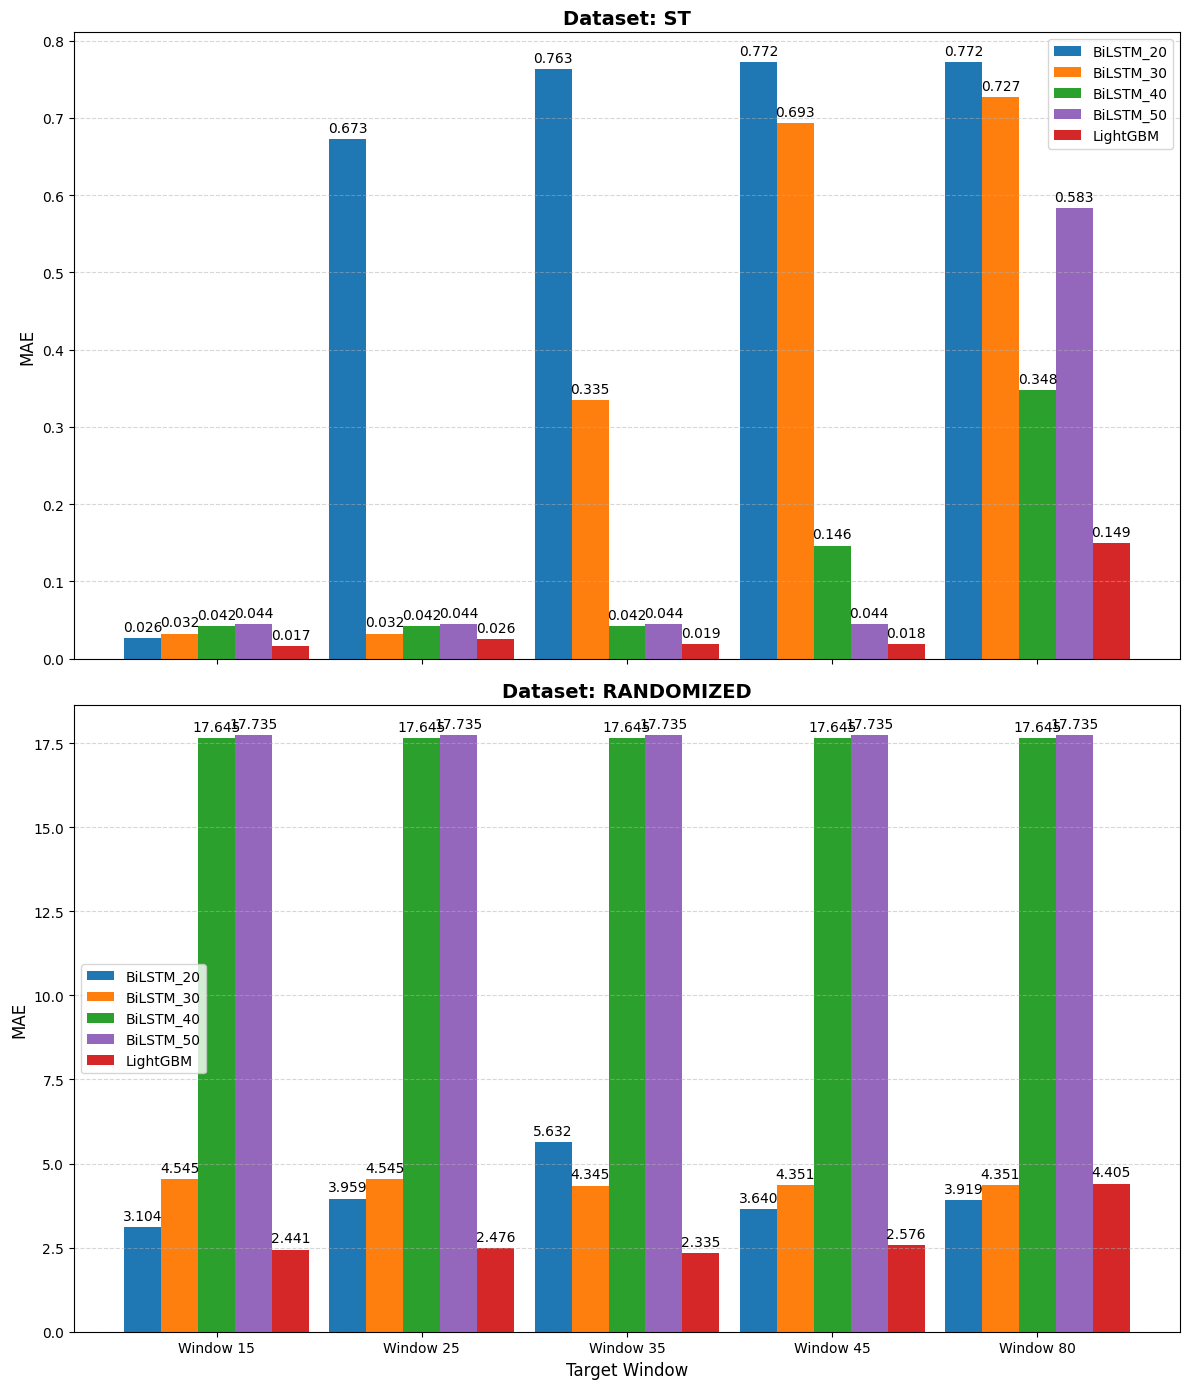

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.losses import MeanSquaredError

# Extend to multiple target windows with subfigures for each dataset
target_windows = [15, 25, 35, 45, 80]
# Parameters
bilstm_windows = [20, 30, 40, 50]  # Different BiLSTM window lengths
width = 0.18  # Decrease bar width to accommodate more models

# Figure setup
datasets = ["st", "randomized"]
fig, axes = plt.subplots(nrows=len(datasets), ncols=1, figsize=(12, 14), sharex=True)
colors = {
    "BiLSTM_20": "#1f77b4", 
    "BiLSTM_30": "#ff7f0e", 
    "BiLSTM_40": "#2ca02c", 
    "BiLSTM_50": "#9467bd",  # New color added for BiLSTM_50
    "LightGBM": "#d62728"
}

for i, ds_name in enumerate(datasets):
    ax = axes[i]
    bilstm_maes_dict = {f"BiLSTM_{w}": [] for w in bilstm_windows}
    lgbm_maes = []
    x_labels = []

    for target_window in target_windows:
        # Load parameters
        params_lgb = load_parameters("training/lightgbm.yaml", dataset_override=ds_name)

        for bilstm_window in bilstm_windows:
            params_bilstm = load_parameters("training/bilstm.yaml", dataset_override=ds_name)

            # Prepare BiLSTM data
            (_, _, _, _, test_s_bi, test_t_bi) = preprocess_and_window(
                data_path=params_bilstm.data_path,
                sequence_length=bilstm_window,
                overlap=params_bilstm.overlap,
                normalize=params_bilstm.normalize,
                features=params_bilstm.features,
                labels=params_bilstm.labels,
                data_groupby=params_bilstm.data_groupby
            )

            if bilstm_window < target_window:
                pad_len = target_window - bilstm_window
                test_s_bi = np.pad(test_s_bi, ((0, 0), (pad_len, 0), (0, 0)), mode='constant')

            bilstm_path = f"models/bilstm/{ds_name}_bilstm_win{bilstm_window}.h5"
            if os.path.exists(bilstm_path):
                model_bi = tf.keras.models.load_model(bilstm_path, custom_objects={'mae': MeanSquaredError()})
                pred_bi = model_bi.predict(test_s_bi)
                mae_bi = mean_absolute_error(test_t_bi, pred_bi)
            else:
                mae_bi = None

            # Collect MAEs for each BiLSTM window
            bilstm_maes_dict[f"BiLSTM_{bilstm_window}"].append(mae_bi if mae_bi is not None else np.nan)

        # Prepare LightGBM data
        (_, _, _, _, test_s_lgb, test_t_lgb) = preprocess_and_window(
            data_path=params_lgb.data_path,
            sequence_length=target_window,
            overlap=params_lgb.overlap,
            normalize=params_lgb.normalize,
            features=params_lgb.datasets[ds_name]['raw_features'],
            labels=params_lgb.labels,
            data_groupby=params_lgb.data_groupby
        )

        test_s_lgb = extract_features(test_s_lgb, params_lgb.raw_features, params_lgb.feature_list)
        lgbm_model_path = f"models/lightgbm/lgbm_{ds_name}_model.pkl"
        if os.path.exists(lgbm_model_path):
            with open(lgbm_model_path, "rb") as f:
                model_lgb = pickle.load(f)
            pred_lgb = model_lgb.predict(test_s_lgb)
            mae_lgb = mean_absolute_error(test_t_lgb, pred_lgb)
        else:
            mae_lgb = None

        # Collect MAEs for LightGBM
        lgbm_maes.append(mae_lgb if mae_lgb is not None else np.nan)
        x_labels.append(f"Window {target_window}")

    # Plotting
    x = np.arange(len(target_windows))  # the label locations
    offset = -width * (len(bilstm_windows) / 2)  # Offset for multiple bars

    for j, (bilstm_label, bilstm_maes) in enumerate(bilstm_maes_dict.items()):
        ax.bar(x + offset + j * width, bilstm_maes, width, label=bilstm_label, color=colors[bilstm_label])

    ax.bar(x + offset + len(bilstm_windows) * width, lgbm_maes, width, label='LightGBM', color=colors["LightGBM"])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('MAE', fontsize=12)
    ax.set_title(f'Dataset: {ds_name.upper()}', fontsize=14, weight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.legend()

    # Annotate bars with values
    for rects in ax.patches:
        height = rects.get_height()
        if not np.isnan(height):
            ax.annotate(f'{height:.3f}',
                        xy=(rects.get_x() + rects.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)

    ax.grid(True, linestyle='--', alpha=0.5, axis='y')

# Shared X-axis label
axes[-1].set_xlabel('Target Window', fontsize=12)
plt.tight_layout()
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  


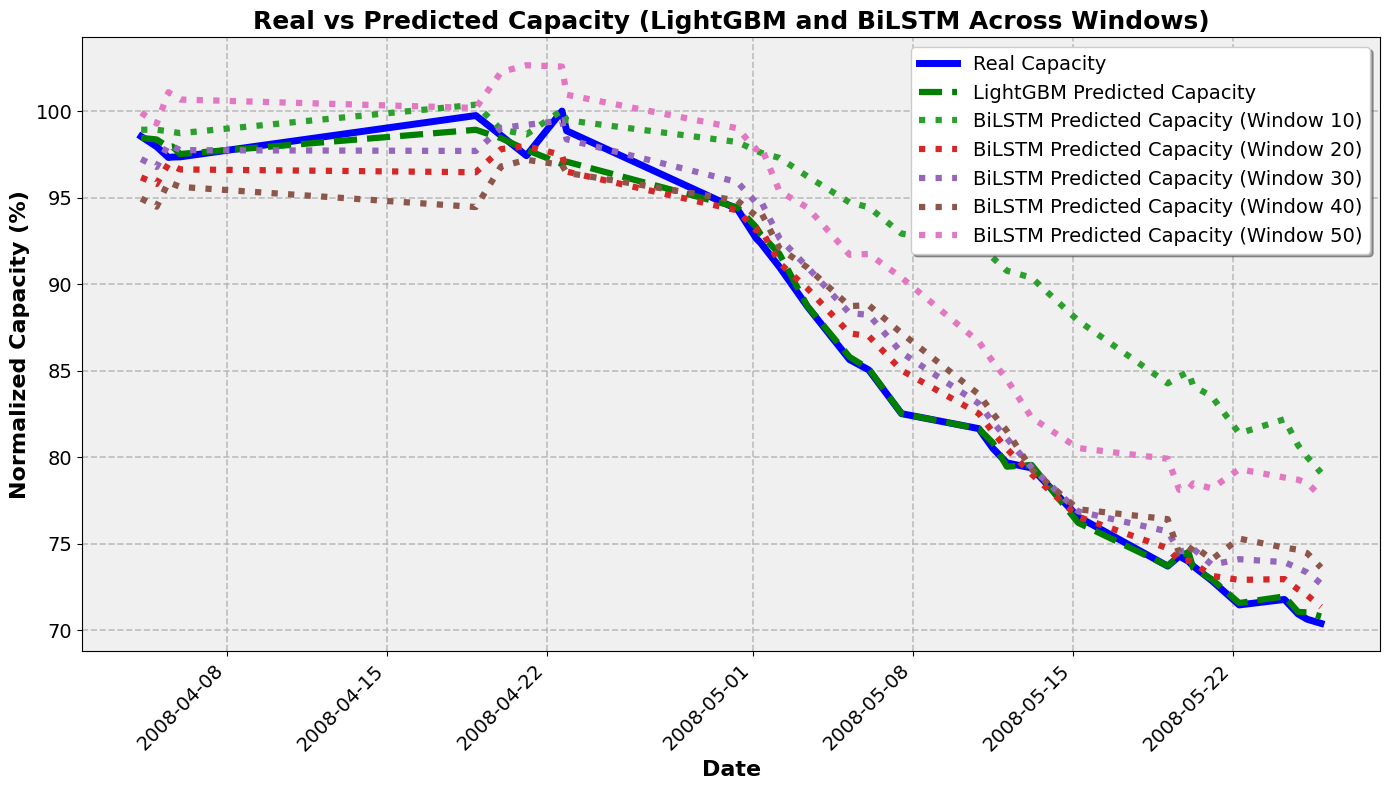

In [15]:
# Define a function to plot results for multiple windows
def plot_results_for_windows(window_sizes, bilstm_model_dict, best_lgbm_model, test_dates, y_test_windows, preds_lgb, preds_bilstm):
    plt.figure(figsize=(14, 8))
    for i, w in enumerate(window_sizes):
        # Load BiLSTM model for the current window size
        bilstm_model_path = bilstm_model_dict.get(str(w))
        if bilstm_model_path:
            model_bilstm = tf.keras.models.load_model(bilstm_model_path, custom_objects={'mae': MeanSquaredError()})
            preds_bilstm = model_bilstm.predict(X_test_windows_bilstm)  # Update predictions for BiLSTM

        # Adjust dates for the current window size
        adjusted_dates = test_dates[:len(y_test_windows)]

        # Normalize capacities for plotting
        real_capacity = y_test_windows.ravel()
        normalized_real_capacity = real_capacity / np.max(real_capacity) * 100
        normalized_preds_lgb = preds_lgb.ravel() / np.max(real_capacity) * 100
        normalized_preds_bilstm = preds_bilstm.ravel() / np.max(real_capacity) * 100
        # Combine the values into a single DataFrame
        combined_df = pd.DataFrame({
            'Date': pd.to_datetime(adjusted_dates),
            'Real Capacity': normalized_real_capacity.ravel(),
            'LightGBM Predicted Capacity': normalized_preds_lgb,
            'BiLSTM Predicted Capacity': normalized_preds_bilstm
        })

        # Group by date and take the mean
        final = combined_df.groupby('Date').mean()
        # Plot real vs predicted for LightGBM and BiLSTM
        if i == 0:  # Plot real capacity and LightGBM only once
            plt.plot(final['Real Capacity'], label="Real Capacity", linewidth=5, linestyle="-", color="blue")
            plt.plot(final['LightGBM Predicted Capacity'], label="LightGBM Predicted Capacity", linewidth=4.5, linestyle="--", color="green")
        plt.plot(final['BiLSTM Predicted Capacity'], label=f"BiLSTM Predicted Capacity (Window {w})", linewidth=4.5, linestyle=":", color=f"C{i+2}")

    # Add labels, legend, and title
    plt.xlabel("Date", fontsize=16, fontweight='bold')
    plt.ylabel("Normalized Capacity (%)", fontsize=16, fontweight='bold')
    plt.title("Real vs Predicted Capacity (LightGBM and BiLSTM Across Windows)", fontsize=18, fontweight='bold')
    plt.legend(fontsize=14, loc='upper right', frameon=True, shadow=True, fancybox=True)
    # Enhance the plot
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.grid(visible=True, linestyle='--', alpha=0.8, linewidth=1.2)  # Enhance grid visibility
    plt.gca().set_facecolor('#f0f0f0')  # Set a light background color for better contrast
    plt.show()

# Call the function with updated parameters
plot_results_for_windows(window_sizes, model_bilstm_dict, model_lgb, test_dates, y_test_windows, preds_lgb, preds_bilstm)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


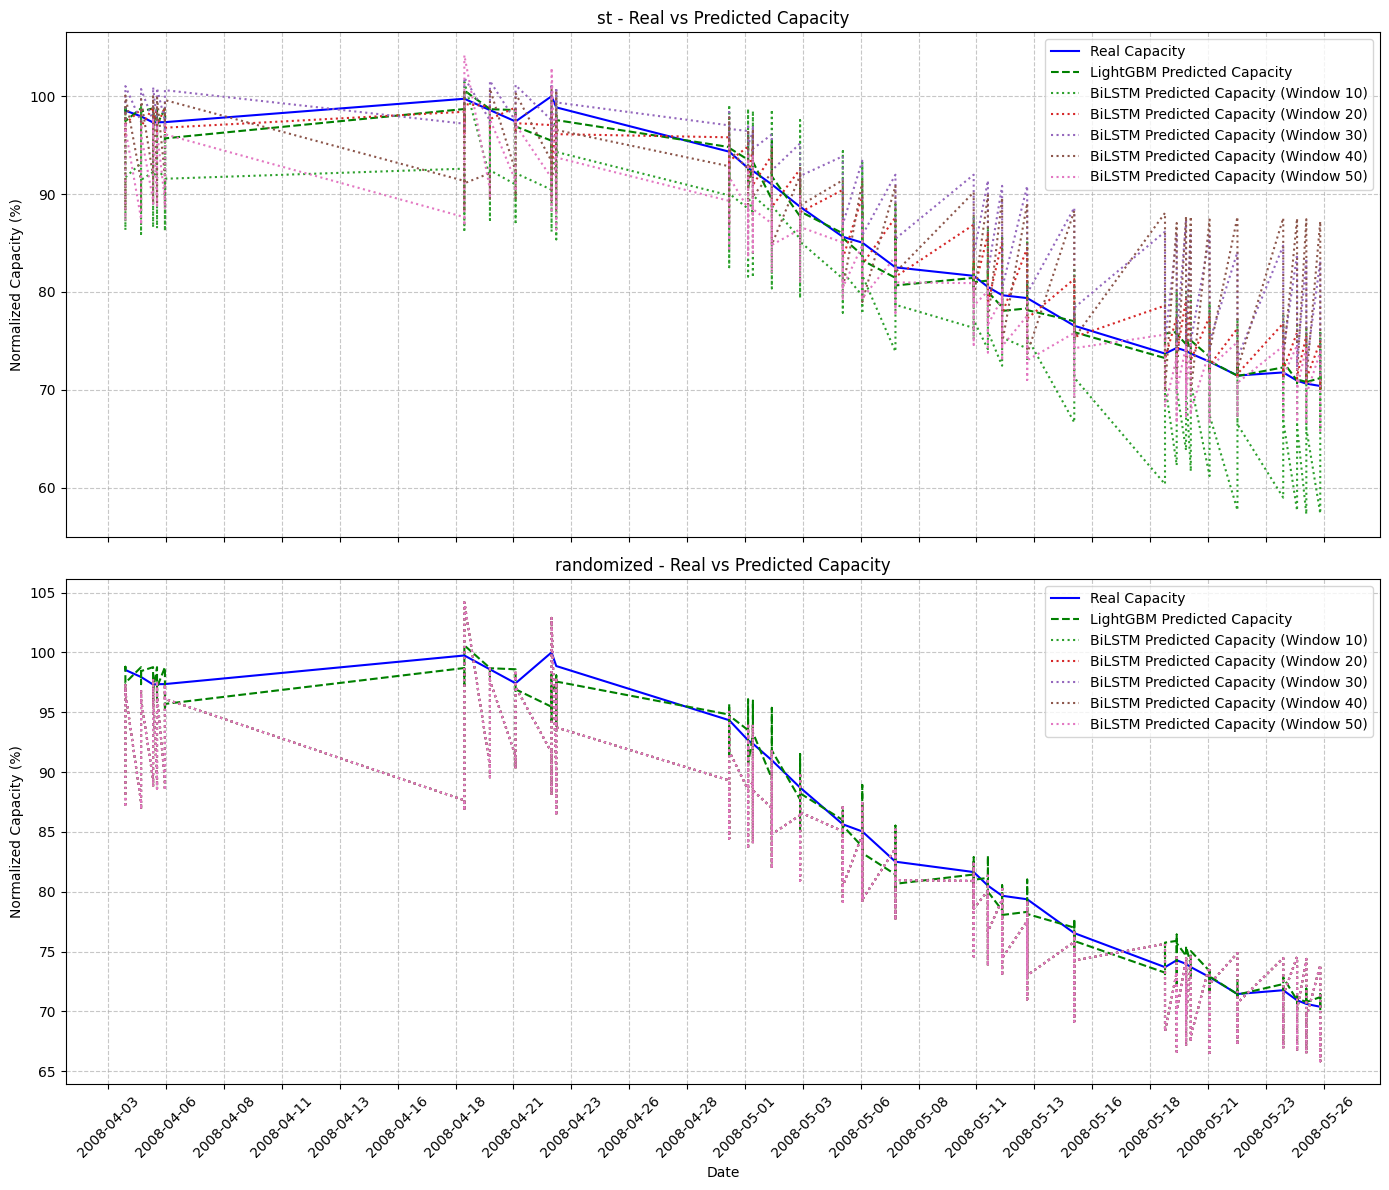

In [ ]:

# Adjust x-axis frequency and add subplots for multiple datasets#
# Adjust x-axis frequency and add subplots for multiple datasets
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 12), sharex=True)

for idx, dataset_name in enumerate(["st", "randomized"]):  # Replace with actual dataset names
    ax = axes[idx]
    # Define the bilstm_model_dict if not already defined
    bilstm_model_path = f'models/bilstm/{dataset_name}_bilstm_'
    bilstm_model_dict = {
        '10': f'{bilstm_model_path}win10.h5',
        '20': f'{bilstm_model_path}win20.h5',
        '30': f'{bilstm_model_path}win30.h5',
        '40': f'{bilstm_model_path}win40.h5',
        '50': f'{bilstm_model_path}win50.h5',
    }
    for i, w in enumerate(window_sizes):
        # Load BiLSTM model for the current window size
        bilstm_model_path = bilstm_model_dict.get(str(w))
        if bilstm_model_path:
            model_bilstm = tf.keras.models.load_model(bilstm_model_path, custom_objects={'mse': MeanSquaredError()})
            preds_bilstm = model_bilstm.predict(X_test_windows_bilstm)  # Update predictions for BiLSTM

        # Adjust dates for the current window size
        adjusted_dates = pd.to_datetime(test_dates[:len(y_test_windows)])
        if dataset_name == "st":
            # Normalize capacities for plotting
            real_capacity = y_test_windows.ravel()
            normalized_real_capacity = real_capacity / np.max(real_capacity) * 100
            normalized_preds_lgb = preds_lgb.ravel() / np.max(real_capacity) * 100
            normalized_preds_bilstm = preds_bilstm.ravel() / np.max(real_capacity) * 100

        # Plot real vs predicted for LightGBM and BiLSTM
        if i == 0:  # Plot real capacity and LightGBM only once
            ax.plot(adjusted_dates, normalized_real_capacity, label="Real Capacity", linestyle="-", color="blue")
            ax.plot(adjusted_dates, normalized_preds_lgb, label="LightGBM Predicted Capacity", linestyle="--", color="green")
        ax.plot(adjusted_dates, normalized_preds_bilstm, label=f"BiLSTM Predicted Capacity (Window {w})", linestyle=":", color=f"C{i+2}")

    # Enhance the subplot
    ax.set_title(f"{dataset_name} - Real vs Predicted Capacity")
    ax.set_ylabel("Normalized Capacity (%)")
    ax.legend()
    ax.grid(visible=True, linestyle='--', alpha=0.7)

# Set common x-axis label and adjust x-axis frequency
axes[-1].set_xlabel("Date")
for ax in axes:
    ax.xaxis.set_major_locator(plt.MaxNLocator(25))  # Reduce the frequency of x-axis ticks
    ax.tick_params(axis='x', rotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()